# 13 - Exploration of Historical NBA Players (Part IV, PCA on Advanced Metrics & By Era)

## Advanced Metrics

Okay, so at this point, I've seen some of the benefits of data exploration methods. I really liked the PCA bi-plot for reasons I rambled about in the last post, namely the balance between interpretability and the value of information provided. Here, I'm just going to throw it at some of the advanced metrics we have within the basketball-reference database. Our objective? I guess at a high level, I'm trying to see how metrics correlate blah blah blah, but I think at this point I'm kinda just putting different lego pieces together and letting the data and algorithms do the talking.

![](http://25.media.tumblr.com/8cbaec1343c83149a8286eec5dee9027/tumblr_n2od7lLOmS1s852lfo1_400.gif)

In [126]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [127]:
%%R
# Load libraries & initial config
library(ggplot2)
library(gridExtra)
library(scales)

In [128]:
# Load libraries & initial config
%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [129]:
# Retrieve team stats from S3
playerAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfToAnalyze.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfToAnalyze.dtypes))
print playerAggDfToAnalyze.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [130]:
# Filter to remove outliers, player must have played over 10 minutes and in over 20 games on the season
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

In [131]:
# Select features
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'per100Stats_FGA',
    'per100Stats_3PA',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]]

# Check for na values in each column
for column in playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.columns:
    print 'there are {} na values in the column {}'.format(
        len(playerAggDfToAnalyzeMin10Min20GamesPCAFeatures[pd.isnull(playerAggDfToAnalyzeMin10Min20GamesPCAFeatures[column])]),
        column
    )

there are 0 na values in the column perGameStats_Pos
there are 0 na values in the column per100Stats_FGA
there are 0 na values in the column per100Stats_3PA
there are 0 na values in the column per100Stats_2PA
there are 0 na values in the column per100Stats_2PPerc
there are 0 na values in the column per100Stats_FTA
there are 3 na values in the column per100Stats_FTPerc
there are 0 na values in the column per100Stats_ORB
there are 0 na values in the column per100Stats_DRB
there are 0 na values in the column per100Stats_AST
there are 0 na values in the column per100Stats_STL
there are 0 na values in the column per100Stats_BLK
there are 0 na values in the column per100Stats_TOV
there are 0 na values in the column per100Stats_PF
there are 0 na values in the column per100Stats_PTS
there are 0 na values in the column advancedStats_PER
there are 0 na values in the column advancedStats_TSPerc
there are 0 na values in the column advancedStats_ORBPerc
there are 0 na values in the column advancedS

From a data quality persective, the data looks good! We'll remove the 3 players without FT% like we have been doing before and get on with our lives.

In [132]:
# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'per100Stats_FGA',
    'per100Stats_3PA',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]].dropna()

playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_Pos']
playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.drop('perGameStats_Pos', 1)

I think I may be getting too liberal here... is that too many features? Probably... nay, yes. Yes, it is. But I've been saying this since the beginning, you gotta fail fast and fail hard!

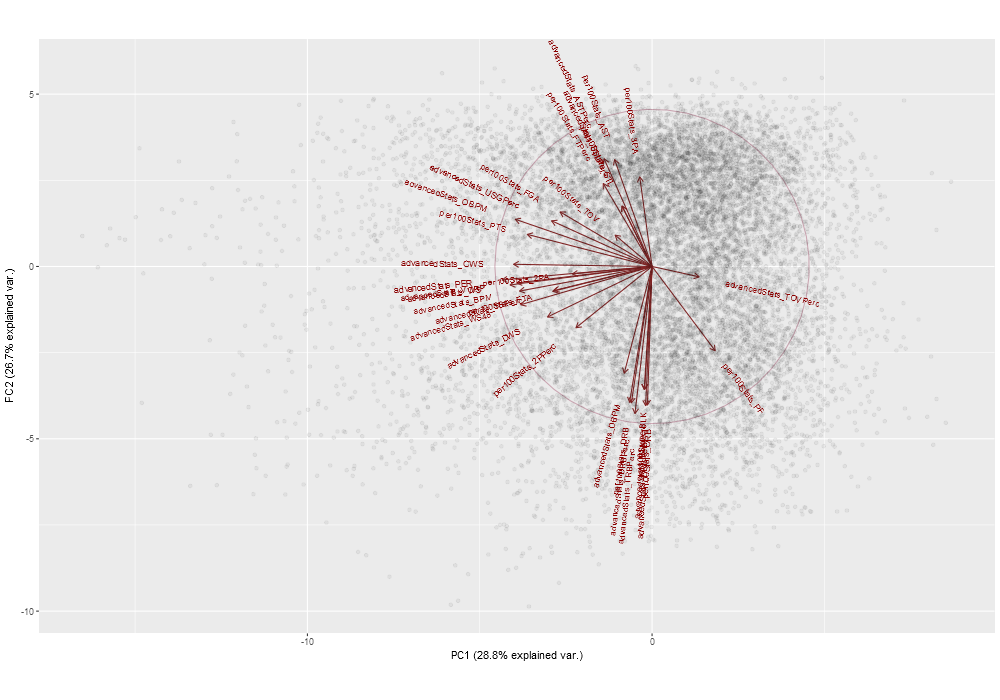

In [133]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel -i playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData -w 1000 -h 700 -u px

library(ggbiplot)

# Fit PCA model
advancedPca = prcomp(playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData, center = T, scale = T)
ggbiplot(advancedPca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.05)

That's a goddamn mess. I apologize for this garbage. There actually is something to be taken away from it, but I honestly just have a hard time reading it basically. Let me hand pick a few that actually make sense.

In [134]:
# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]].dropna()

playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_Pos']
playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.drop('perGameStats_Pos', 1)

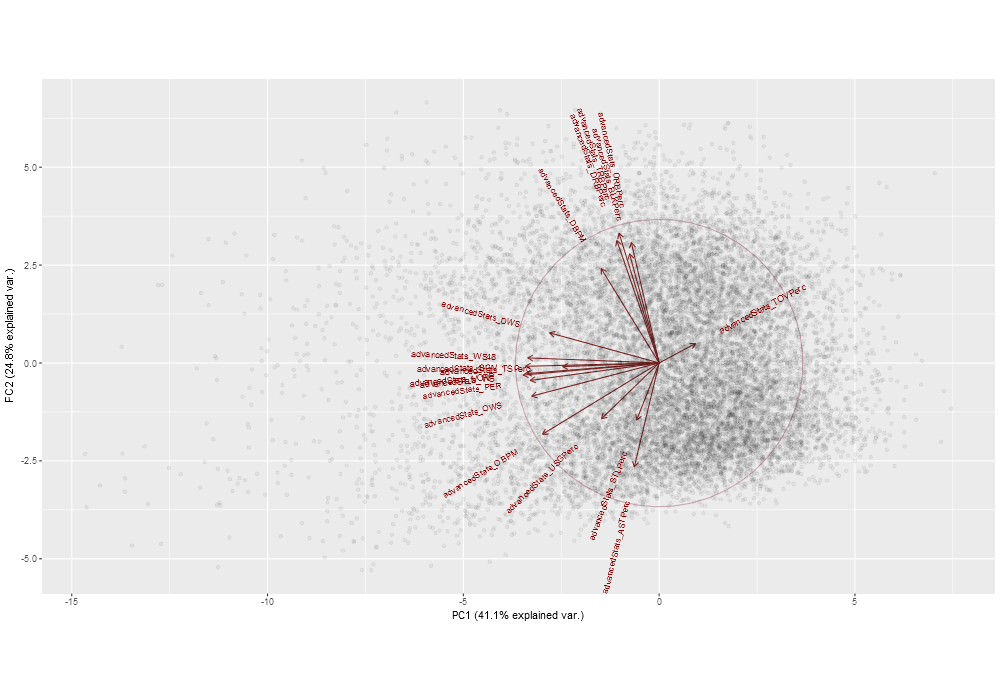

In [135]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel -i playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData -w 1000 -h 700 -u px

library(ggbiplot)

# Fit PCA model
advancedPca = prcomp(playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData, center = T, scale = T)
ggbiplot(advancedPca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.05)

I tried to color the points by position again but for some reason it ran out of memory, giving me the error...
> RRuntimeError: Error: cannot allocate vector of size 128 Kb

I'm going to ignore this error for now as I can kind of guess how the points are distributed here. We see the usual suspects AST / STL in one corner (presumably guards) and ORB / DRB / BLK / TRB in the other corner (presumably big men).

We also see the more all-encapsulating metrics WS / TS / PER are all agnostic to position and are all proportional in the same direction. Higher TS players have higher PER and higher WS.

Some other things to note:
- Guards have higher USG%, makes sense, they usually handle the ball
- Big men lose the ball at a higher rate, makes sense, they usually _**can't**_ handle the ball
- Guards are slightly more responsible for OWS and big men are slightly more responsible for DWS, but in general, the are blurred
- DBPM is largely anchored by big men... I feel like if we look at this among eras we might see this change a bit more? I could see how back in the day having a big man clog up the lane in the middle would deter opposing offensive movement
- OBPM is more attributed to guards, but not as much as DBPM is attributed to big men. This could make sense because your guards are your more traditional closers and 3 point shooters, and good 3 point shooters nowaday are becoming more efficient than a good 50% low post scorer

I wonder if PCA-ing on only the all-encapsulating metrics will provide any more information...

In [136]:
# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'advancedStats_PER',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]].dropna()

playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesLabel = playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeatures['perGameStats_Pos']
playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeatures.drop('perGameStats_Pos', 1)

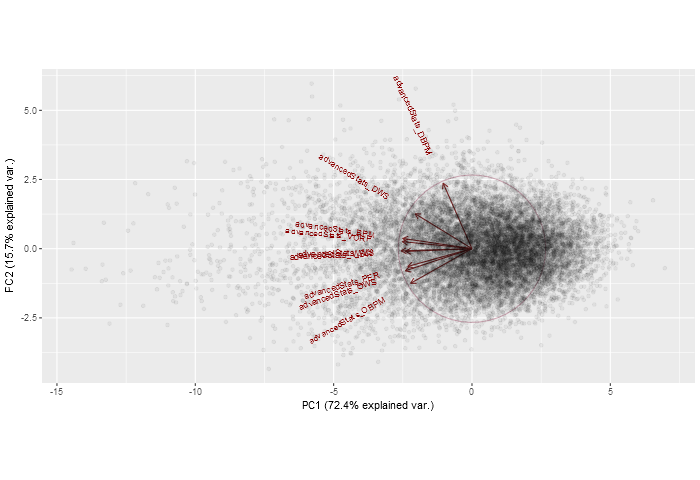

In [137]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesLabel -i playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesData -w 700 -u px

# Fit PCA model
advancedAllEncapPca = prcomp(playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesData, center = T, scale = T)
ggbiplot(advancedAllEncapPca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.05)

Nothing too crazy. It essentially just magnifies some of the differences due to the different view on variance. Nothing we can't get from the other plot.

## By Era
As I've mentioned multiple times, I think if we looked at a plot of the players in the 80's, 90's, 00's, and 10's, we'd see some differences due to the playing style change. For this, I'm going to revert back to some of the original metrics we have. I think using the advanced metrics at this point would be getting ahead of myself. Let's start from the basics again.

In [138]:
playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra = {}

for year in [1980, 1990, 2000, 2010]:
    # Generate key of dict
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[year] = {}
    
    # Select subset of features
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[year]['all'] = playerAggDfToAnalyzeMin10Min20Games[
        (playerAggDfToAnalyzeMin10Min20Games['season_start_year'] >= year) & (playerAggDfToAnalyzeMin10Min20Games['season_start_year'] < year + 10)
    ][[
        'perGameStats_Pos',
        'per100Stats_FGA',
        'per100Stats_3PA',
        'per100Stats_2PA',
        'per100Stats_2PPerc',
        'per100Stats_FTA',
        'per100Stats_FTPerc',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK',
        'per100Stats_TOV',
        'per100Stats_PF',
        'per100Stats_PTS'
    ]].dropna()

    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[year]['label'] = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[year]['all']['perGameStats_Pos']
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[year]['data'] = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[year]['all'].drop('perGameStats_Pos', 1)

Hmm, I've ran into a technical problem with the rpy2 library with Jupyter unfortunately. 4 data frames, one for each decade 1980's, 1990's, 2000's, and 2010's. They're structured within the dict _**playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra**_, and the first level labels are the starting year of the decades.

It was easy to generate this data in python, but unfortunately I can't pass the entire dict to R, and it's a bit messy to pass in 8 dataframes (2 for each decade, one for the quantitative data and one for the positional labels). For the purposes of this post specifically, I don't want to do anything more fancy from a scripting perspective. I'll just logically separate the rest of my post into the eras and pass in the dataframes era by era.

### 1980's

In [139]:
# Rename dataframes so we can pass to R
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1980Data = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[1980]['data']
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1980Label = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[1980]['label'].tolist()

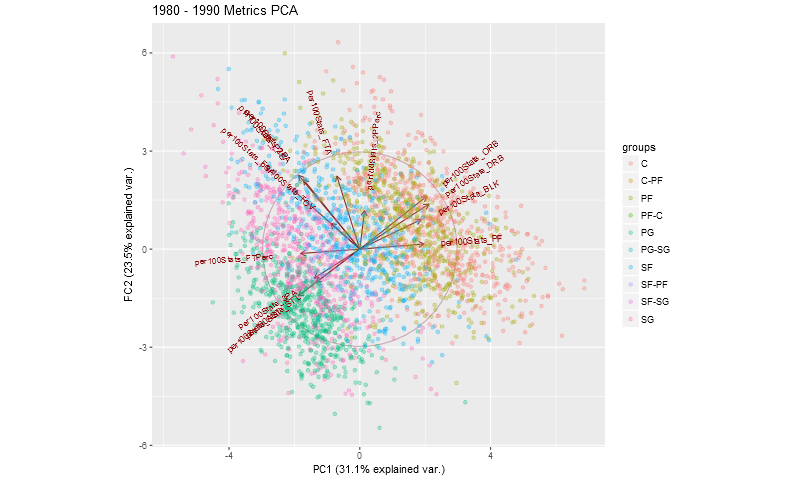

In [184]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1980Data -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1980Label -w 800 -u px

# Fit PCA model
pcaAnalyzeAndOutput = function(year, data, labels){
    pca = prcomp(data, center = T, scale = T)
    
    pcaBiplot = ggbiplot(pca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.3, groups = labels) +
    ggtitle(sprintf('%s - %s Metrics PCA', year, year + 10))
    
    return(pcaBiplot)
}

pcaPlot1980 = pcaAnalyzeAndOutput(1980, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1980Data, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1980Label)
pcaPlot1980

### 1990's

In [141]:
# Rename dataframes so we can pass to R
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1990Data = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[1990]['data']
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1990Label = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[1990]['label'].tolist()

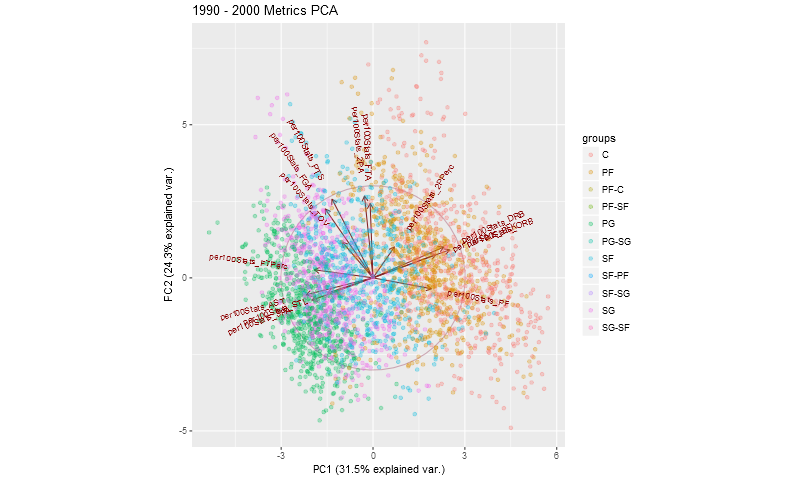

In [142]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1990Data -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1990Label -w 800 -u px
pcaPlot1990 = pcaAnalyzeAndOutput(1990, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1990Data, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures1990Label)
pcaPlot1990

### 2000's

In [143]:
# Rename dataframes so we can pass to R
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2000Data = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[2000]['data']
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2000Label = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[2000]['label'].tolist()

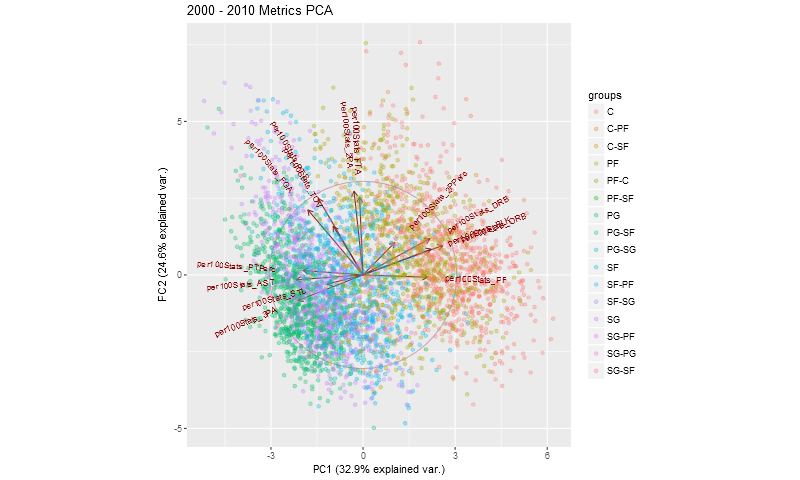

In [144]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2000Data -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2000Label -w 800 -u px
pcaPlot2000 = pcaAnalyzeAndOutput(2000, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2000Data, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2000Label)
pcaPlot2000

### 2010's

In [145]:
# Rename dataframes so we can pass to R
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2010Data = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[2010]['data']
playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2010Label = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByEra[2010]['label'].tolist()

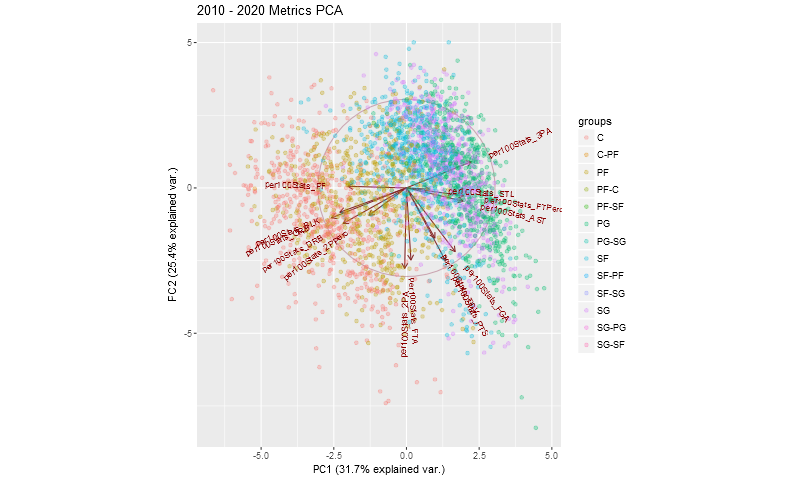

In [146]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2010Data -i playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2010Label -w 800 -u px
pcaPlot2010 = pcaAnalyzeAndOutput(2010, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2010Data, playerAggDfToAnalyzeMin10Min20GamesPCAFeatures2010Label)
pcaPlot2010

This is a bit hard to see... let's try to plot all these together.

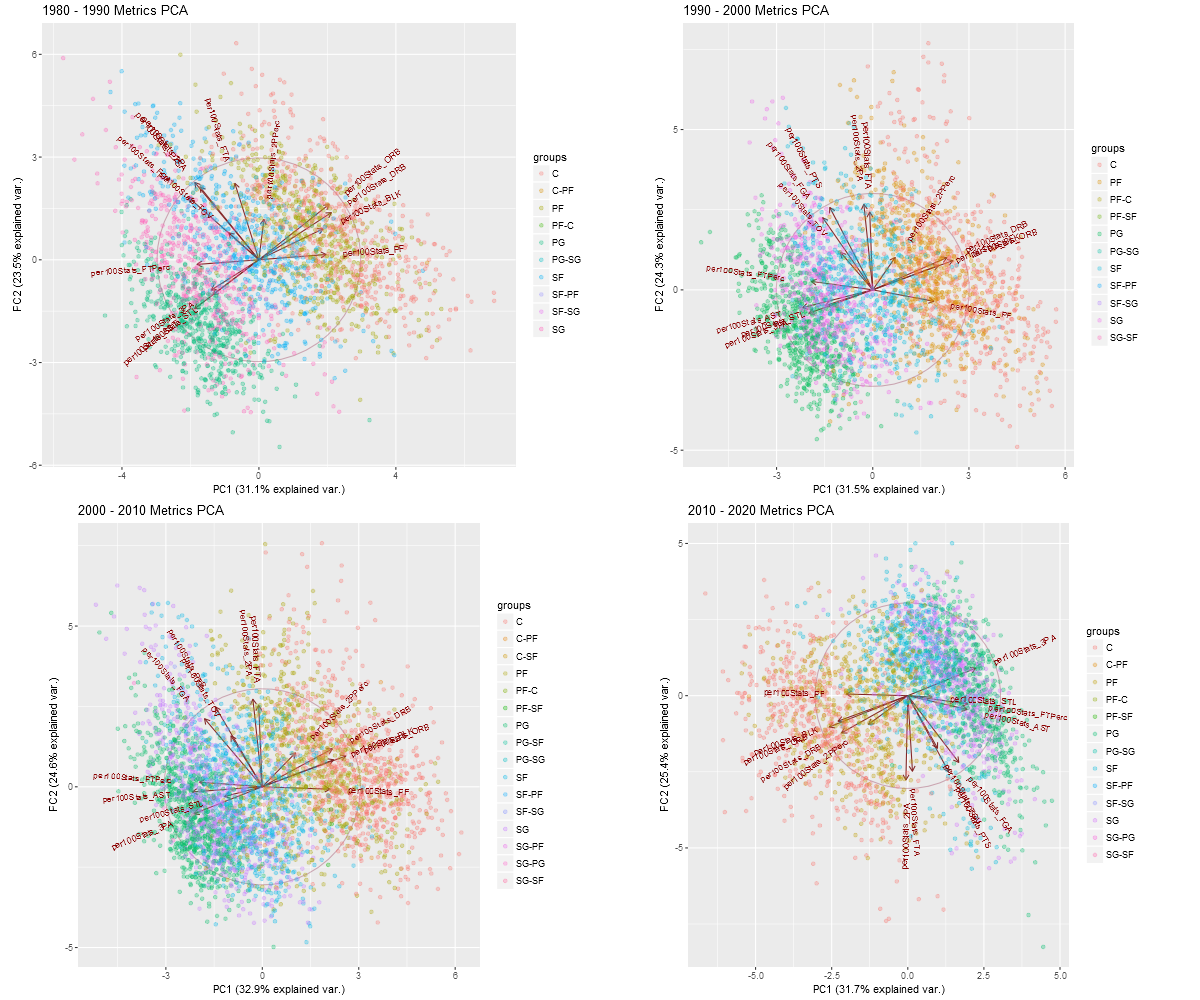

In [147]:
%%R -w 1200 -h 1000 -u px
grid.arrange(
    pcaPlot1980 + guides(fill = FALSE), 
    pcaPlot1990, 
    pcaPlot2000, 
    pcaPlot2010, 
    ncol = 2
)

NOTES IN NO PARTICULAR ORDER... this seems to be a pattern now... is it healthy to just write things down with no goals or objectives or does this basically confirm I have ADD?

![](http://bestanimations.com/Books/writing/pusheen-writing-book-animated-gif.gif)

_**PCA Notes**_
- Yes! We finally get some hint that the **ordering on the axis don't really matter**, i.e. whether the coefficients of the principal components are positive or negative, they don't matter!
    - The directions of the principal component vectors mean something **in relation to each other**, i.e. it matters that 3PA is generally pointing the opposite direction of BLK, but whether 3PA is positive or negative doesn't matter!
    - In the 2010's PCA bi-plot, the direcitons are completely flipped, but they generate the same information

_**PCA Vectors Notes**_
- In the **80's**, what it meant to be a guard and forward from a stats perspective seems a lot more defined
    - This was similar to what we saw in our previous bi-plots of base stats, guards get AST / STL / 3PA, and big men get RB / BLK, and this is honestly still the connotation I hear in my head TBH!
- Fast forward to the **2010's**, the **AST / STL** metrics are no longer solely the guards, and are shared in part by big men

_**Scatterplot Notes**_
- It's so interesting to see the division of the groups as time goes on as well, in the **80's**, we see a pretty clear separation between **PG / SG / SF / PF / C**... the C's and PF's are melted together a bit, but you get the idea
- Fast forward to the **2010's**, what is a guard? What is a forward? Your PG's and SG's are basically the same beast. Even your SF's are almost the same beast. If we think about player like "Lebron" who might on any given night do more distributing than any PG on the Cavs, it definitely makes sense. You'll also get Lebron stuffing the stat sheet with Rebounds, Blocks, great shooting splits... he does it all, so it would be interesting to see where he lies on these graphs. Probably somewhere smack dab in the middle.

You know what... on that point... let's check it out!

### Players On CPA Bi-Plot
I'm going to pick some players that I feel both play specific roles really well and other players who don't play a specific role at all and see where they fall on this bi-plot to get an even deeper understanding of what this plot is showing me.

In [191]:
# Filter and create labels for players to be grouped in our ggbiplot
playerAggDfToAnalyzeMin10Min20Games['player_label'] = np.where(
    playerAggDfToAnalyzeMin10Min20Games['perGameStats_Player'].str.lower().replace('\W', '', regex = True).str.contains(
        'lebron|shanebattier|michaeljordan|shaq|benwallace|stephencurry|jamesharden|luclongley|larrybird|stockton'
    ),
    playerAggDfToAnalyzeMin10Min20Games['perGameStats_Player'],
    'Other'
)

# Check that the labels are being applied correctly
print playerAggDfToAnalyzeMin10Min20Games['player_label'].value_counts()

# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayer = playerAggDfToAnalyzeMin10Min20Games[[
    'player_label',
    'per100Stats_FGA',
    'per100Stats_3PA',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS'
]].dropna()

playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayerLabel = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayer['player_label'].tolist()
playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayerData = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayer.drop('player_label', 1)

Other                13085
Shaquille O'Neal*       20
John Stockton*          18
Ben Wallace             16
Shane Battier           15
LeBron James            14
Michael Jordan*         13
Larry Bird*             12
Luc Longley             11
James Harden             8
Stephen Curry            8
Name: player_label, dtype: int64


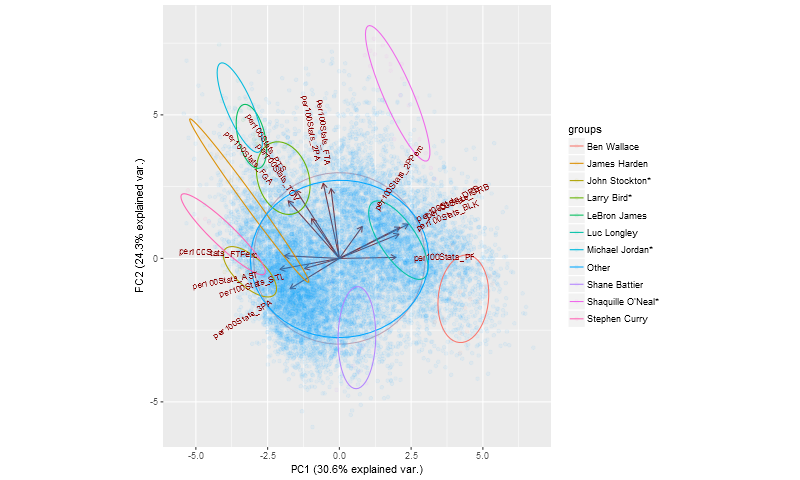

In [190]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayerData -i playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayerLabel -w 800 -u px

# Fit PCA & output bi-plot
playerPca = prcomp(playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayerData, center = T, scale = T)
ggbiplot(playerPca, obs.scale = 1, var.scale = 1, circle = TRUE, ellipse = TRUE, alpha = 0.05, groups = playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesByPlayerLabel)

Alright, this is actually quite interesting now. We're starting to be able to visually map out where on this PCA grid different types of player lie. Let's go through some of these

**General Notes**

Okay, sorry I lied, I'm going to make even more general observations first before I dive into certain players. It seems that, for the most part, the players I've chosen are more or less the elite of the league at the times that they were playing. Most of them lie on the top left hand corner of this graph. We see more dominant scorers at the very top left hand corner. Great guards on the top left hand corner but also leaning towards the G / SG cluster. Great big men (or in this case I guess pretty much Shaq) way over near the big men cluster.

I've thrown in some great players who are not statistical monsters as well (Ben Wallace, Shane Battier) and they're more towards the bottom-right hand corner of the PCA bi-plot. I haven't quite figured out exactly what this area of the plot means yet, but let's focus on the other side first.

**Michael Jordan**

Welp, there you go. MJ, the scoring leader by points per game of the league, very clearly the leader in this plot as well. It seems that high scoring players who are concentrated on scoring also tend to gather a large amount of turnovers and FGA per game as well, and this is something we can definitely believe about Jordan. We see Lebron and Larry Bird right behind Jordan on that same axis as well.

**Lebron**

There's a reason why a 27 / 7 / 7 is called a "Lebron". It's a great statline. This guy's out there scoring points, getting your team members involved, and crashing the boards consistently. I actually find it hard in this plot to hint that Lebron is such an all-around player. In this plot, it looks like he's basically a lesser Michael Jordan. There's a lot that this isn't capturing about his style of play as it differentiated A LOT from MJ.

**Shaq**

Hooooooooooooly. There you go. A player that's about as strong as MJ is on the "scorer" axis, and as great as they come in the "big men" direction or axis as well. There are only a few plotted points where his ellipse is, and it's probably all him.

**Ben Wallace**

Big Ben. With high averages in Rebounds, Blocks, and Steals, and medium / low averages in... pretty much everything else, it's interesting to see where he lies on the graph. It's difficult to interpret how the plot is handling players who have both big men and guard attributes simultaneously. Big Ben was elite in both his block and steal numbers, while he's not a scorer, and we can see that clearly from the plot, the plot kind of does make it seem like he's only an average big man, where he excels in all the big men attributes. Perhaps the fact that he's dragged to the bottom-right hand side of the plot while still remaining at the outer edges of the scatterplot cluster implies that he's attributing some guard qualities as well, and doing it at an elite level. I'd have to explore the different areas of the plot to confirm this.

## Looking Ahead
A few main questions arise here for me, stemming from the analysis of the players I just went through:
- How closely can I map different "types" of players to sections of the plot?
- How can I account for players who exhibit qualities across multiple "types" of players?
- What does that bottom-right hand side of the plot communicate exactly?

Let's dive deeper into these PCA plots in the next post!